<a href="https://colab.research.google.com/github/AshishRaj04/Spectral-classification-of-Chandrayaan-2-IIRS/blob/main/Spectral_classification_of_Chandrayaan_2_IIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the spectral library for reading the **.qub** and **.hdr** files

In [ ]:
! pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.3 MB/s eta 0:00:00


Mount the Gdrive

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specifying the files path to variables

In [ ]:
data_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/data.qub"
header_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/header.hdr"
geometry_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/geometry.csv"

Reading the data

In [ ]:
import spectral
import os

In [ ]:
data = spectral.io.envi.open(header_file, image=data_file)

In [ ]:
hyperspectral_data = data.load()

In [ ]:
print(f"Shape of the data: {hyperspectral_data.shape}")

Shape of the data: (9340, 250, 256)


The shape of the data is (9340 , 250 , 256) .
In the 2D space of 9340 x 250 (lines * samples) each pixel or point has 256 different reflectance values at 256 different wavelengths.

Importing the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Saving the plots using custom `save_fig()` function

In [ ]:
IMAGES_PATH = Path() / "images" / "hyperspectral"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Plot of reflectance variation
The `plot_reflectance_variation(x, y)` below plots the reflectance values with respect to the wavelength at the coordinates specified by the user.
*Coordinates must be in the range of (250 , 9340)*

In [ ]:
def plot_reflectance_variation(x , y):
  if x >= 0 and x < hyperspectral_data.shape[1] and y >= 0 and y < hyperspectral_data.shape[0]:
    reflectance_values = hyperspectral_data[y, x, :]
    plt.figure(figsize = (10 , 6))
    plt.plot(range(hyperspectral_data.shape[2]), reflectance_values.squeeze())
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title(f'Reflectance Variation at ({x}, {y})')
    save_fig("reflectance variation vs wavelength")
    plt.show()
  else:
    print("Invalid coordinates")

Enter the x coordinate: 1
Enter the y coordinate: 1


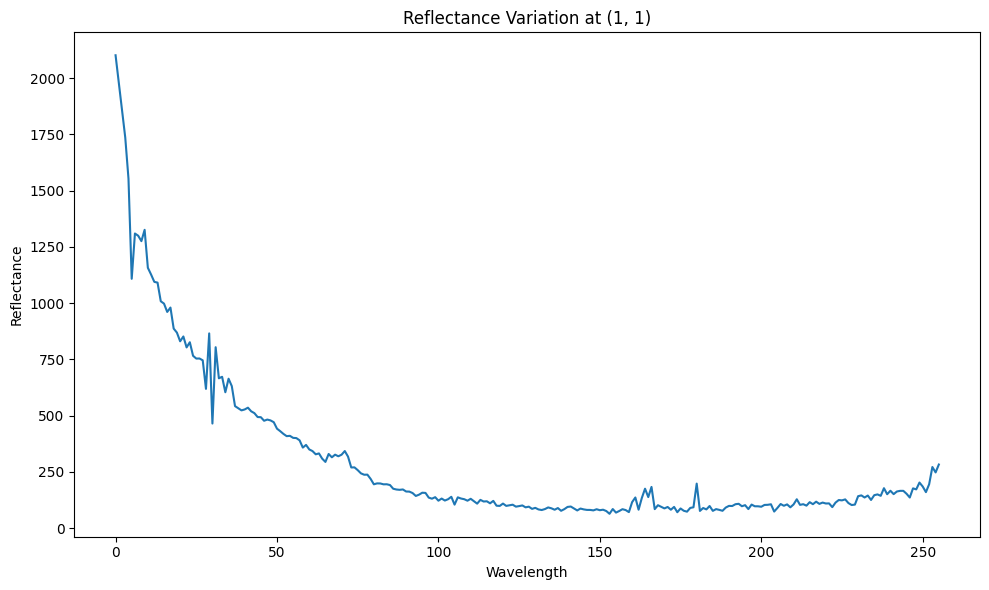

In [ ]:
x = int(input("Enter the x coordinate: "))
y = int(input("Enter the y coordinate: "))
plot_reflectance_variation(x , y)

Plotting the grayscale image of the 9340 x 250 region at 6 different wavelength (bands -  10 , 50 , 100 , 150 , 200 , 256)

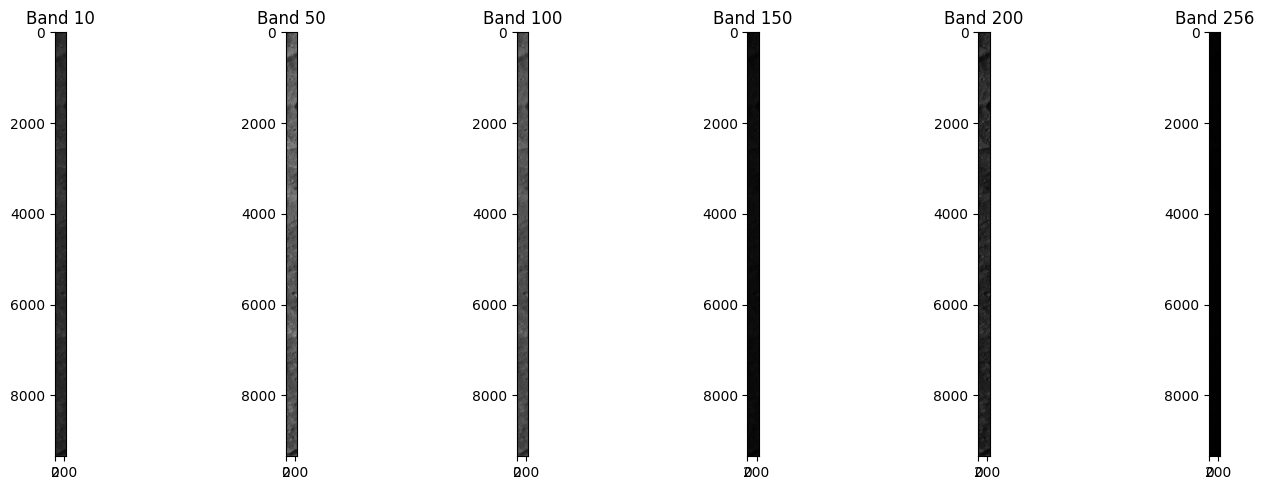

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

axes[0].imshow(hyperspectral_data[:,:,10], cmap='gray')
axes[0].set_title('Band 10')

axes[1].imshow(hyperspectral_data[:,:,50], cmap='gray')
axes[1].set_title('Band 50')

axes[2].imshow(hyperspectral_data[:,:,100], cmap='gray')
axes[2].set_title('Band 100')

axes[3].imshow(hyperspectral_data[:,:,150], cmap='gray')
axes[3].set_title('Band 150')

axes[4].imshow(hyperspectral_data[:,:,200], cmap='gray')
axes[4].set_title('Band 200')

axes[5].imshow(hyperspectral_data[:,:,255], cmap='gray')
axes[5].set_title('Band 256')

save_fig("grayscale image of strip at 6 different bands")

plt.show()

# Plot of moon surface with region of interest along with geographical coordinates at a specific band

In [ ]:
coord_df = pd.read_csv(geometry_file)

In [ ]:
coord_df.head()

,Longitude,Latitude,Pixel,Scan
0,137.556296,13.094611,0,0
1,137.470532,13.093085,50,0
2,137.384799,13.091541,100,0
3,137.299081,13.089978,150,0
4,137.213365,13.088396,200,0


Enter the band: 250


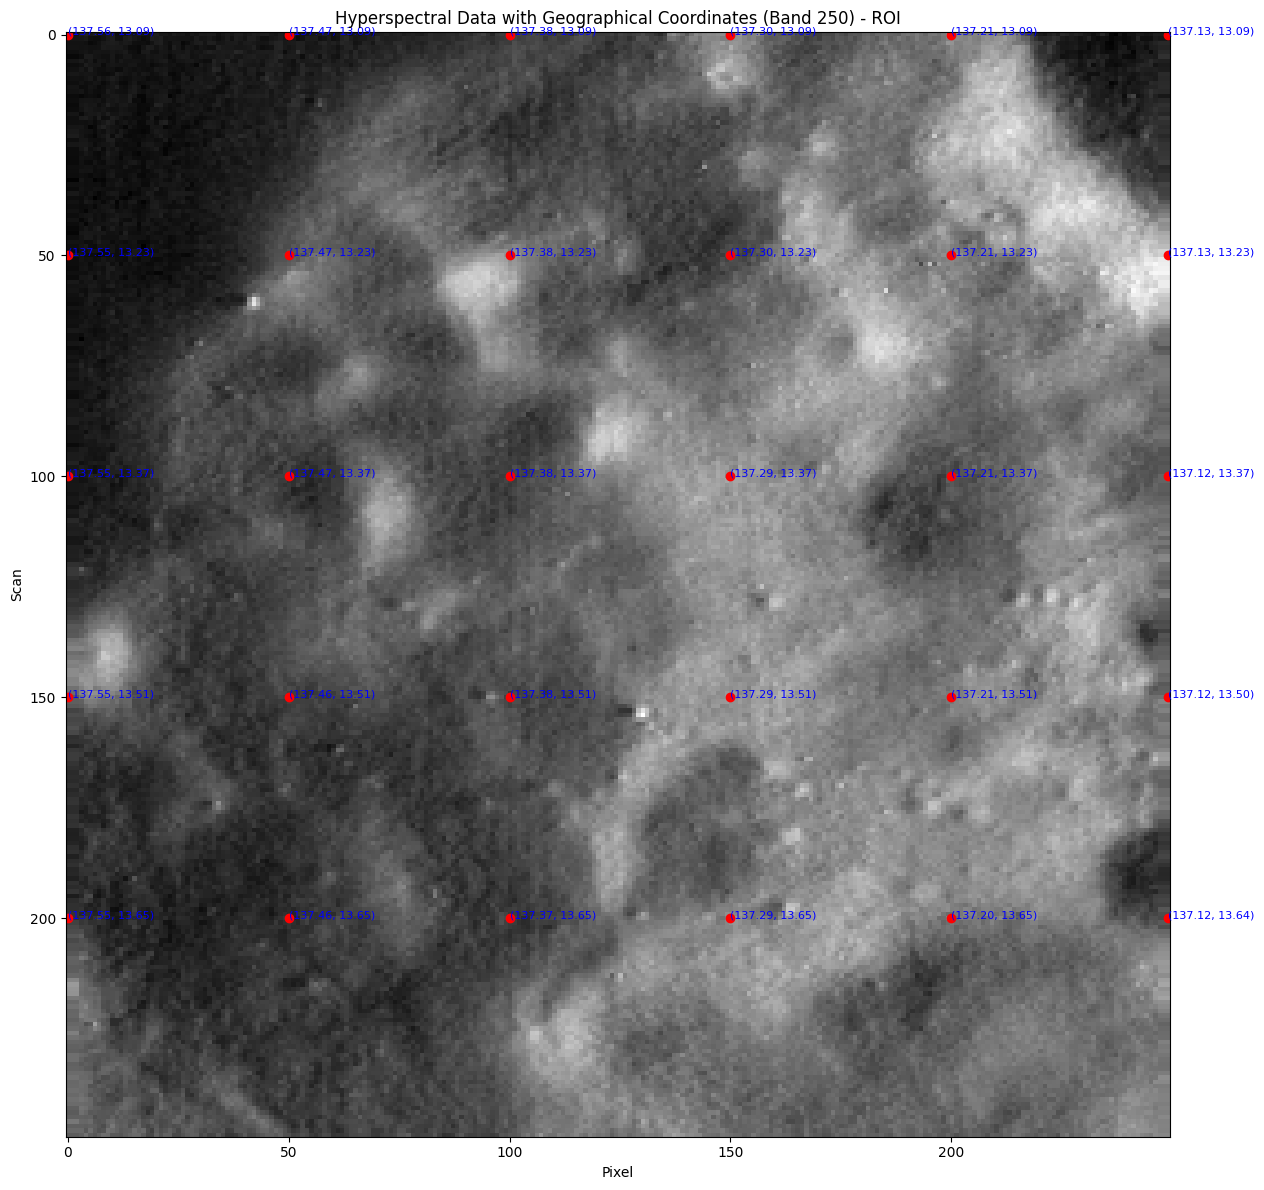

In [ ]:
# roi = region of interest
roi_start_x = 0
roi_end_x = 250
roi_start_y = 0
roi_end_y = 250

def plot_roi_hyperspectral_with_coords(band_index):
    plt.figure(figsize=(20, 12))

    plt.imshow(hyperspectral_data[roi_start_y:roi_end_y, roi_start_x:roi_end_x, band_index], cmap='gray')

    for index, row in coord_df.iterrows():
        pixel = row['Pixel']
        scan = row['Scan']


        if roi_start_x <= pixel < roi_end_x and roi_start_y <= scan < roi_end_y:
            lon = row['Longitude']
            lat = row['Latitude']


            plt.plot(pixel - roi_start_x, scan - roi_start_y, 'ro')
            plt.text(pixel - roi_start_x, scan - roi_start_y, f"({lon:.2f}, {lat:.2f})", color='blue', fontsize=8)

    plt.title(f'Hyperspectral Data with Geographical Coordinates (Band {band_index}) - ROI')
    plt.xlabel('Pixel')
    plt.ylabel('Scan')
    save_fig(f"Image geographical coordinates")
    plt.show()

plot_roi_hyperspectral_with_coords(int(input(f"Enter the band: ")))

# Data Preparation
* Reshaping
* Normalization
* PCA

Normalizing the data by dividing each reflectance value by the maximum reflectance value . In order to achieve values between 0-1. This will improve the traning time of the ml models.

In [ ]:
normalized_data = hyperspectral_data / np.max(hyperspectral_data)

Reducing the dimention of the data to 2-dimentions

In [ ]:
flattened_data = normalized_data.reshape(-1, normalized_data.shape[-1])

In [ ]:
flattened_data.shape

(2335000, 256)

In [ ]:
print(flattened_data[:10])

[[0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 ...
 [0.00331437 0.0033712  0.00342802 ... 0.00046547 0.00038309 0.00039068]
 [0.00738867 0.00678232 0.00617597 ... 0.00046661 0.00077682 0.00094651]
 [0.0087032  0.00805969 0.00741618 ... 0.00044319 0.00048961 0.00045587]]


# Dimensionality Reduction using Principal component analysis

* PCA can further reduce the dimensionality by keeping the most important components, making it more manageable for clustering and CNN processing.
* As you can see the 10 principal components capture 98.31% of the variability in your original hyperspectral data

In [ ]:
pca = PCA(n_components = 10)
reduces_data = pca.fit_transform(flattened_data)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio by 10 components: {explained_variance}")

Explained Variance Ratio by 10 components: 0.983117023754419


In [ ]:
reduces_data.shape

(2335000, 10)

# Clustering

* Applying **k-mean clustering**

Applying k-mean to seperate the data into 5 different clusters . We will use these clusters as labels for classification.

In [ ]:
kmean = KMeans(n_clusters=5)

In [ ]:
labels = kmean.fit_predict(reduces_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def nearest_centroid(X , centroid):
  k = centroid.shape[0]
  c = np.zeros(X.shape[0] , dtype=int)

  for i in range(X.shape[0]):
    distance = []
    for j in range(k):
      norm_ij = np.linalg.norm(X[i] - centroid[j])
      distance.append(norm_ij)
    c[i] = np.argmin(distance)
  return c

def compute_centroid(X , c , k):
  m , n = X.shape
  centroids = np.zeros((k , n))
  for i in range(k):
    centroids[i] = np.mean(X[c == i] , axis = 0)
  return centroids

def initialize_centroid(X , k):
  random_index = np.random.permutation(X.shape[0])
  return X[random_index[:k]]

In [ ]:
def run_kMeans(X, initial_centroids, iter, plot_progress=False):
    m, n = X.shape
    k = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))


    for i in range(iter):
        print("K-Means iteration %d/%d" % (i, iter-1))
        idx = nearest_centroid(X, centroids)
        if plot_progress:
            # plot_progress_kMeans(X, centroids, previous_centroids, idx, k, i)
            previous_centroids = centroids
        centroids = compute_centroid(X, idx, k)
    plt.show()
    return centroids, idx

In [ ]:

k = 5
iter = 4
initial_centroids = initialize_centroid(reduces_data , k)
centroids , c = run_kMeans(reduces_data , initial_centroids , iter )

K-Means iteration 0/3
K-Means iteration 1/3
K-Means iteration 2/3
K-Means iteration 3/3


<Figure size 800x600 with 0 Axes>

In [ ]:
centroids , c.shape , centroids.shape

(array([[ 1.27589116e-02, -1.89938481e-04,  1.05476312e-04,
          6.98281729e-05, -2.50136763e-05, -4.50877778e-05,
         -5.96752761e-05,  5.41556301e-06, -1.09440743e-05,
         -9.44893782e-06],
        [-9.54106916e-03,  1.24019128e-03, -2.47392036e-05,
          3.40005645e-05,  4.40508120e-05, -3.96895848e-05,
         -3.64217522e-05, -3.49121638e-06, -7.07171603e-06,
         -7.12954716e-06],
        [-1.84971184e-04,  3.05269915e-03,  3.99176381e-04,
         -6.86118938e-06, -1.70902877e-05,  3.45906083e-05,
          1.93099113e-05, -2.36688684e-05,  7.23005769e-06,
          1.81765063e-05],
        [-2.92125577e-03, -2.21677939e-03, -1.11999536e-04,
         -2.09463924e-05, -1.30907511e-05,  2.71169611e-05,
          2.30829228e-05,  3.98346019e-05,  7.43608780e-06,
         -5.57829162e-06],
        [ 4.85864840e-03, -1.35467784e-03, -2.63146678e-04,
         -2.45259744e-05,  5.61173511e-06, -1.07676178e-05,
          9.54816187e-06, -1.68106508e-05, -4.218712

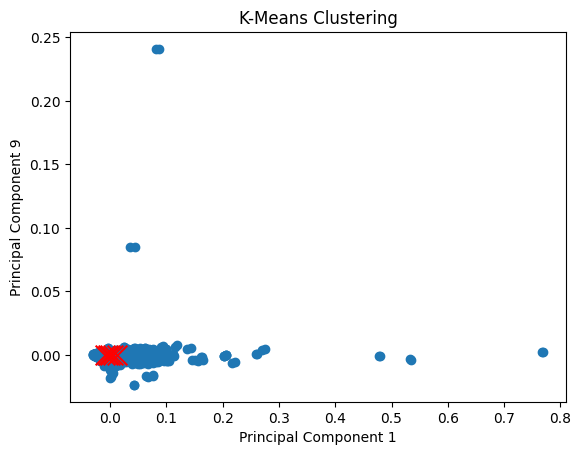

In [ ]:
plt.scatter(reduces_data[:, 0], reduces_data[:, 8])
plt.scatter(centroids[:, 0], centroids[:, 8], marker='x', color='red', s=200)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 9")
plt.show()

In [ ]:
clustered_image = labels.reshape(hyperspectral_data.shape[0] , hyperspectral_data.shape[1])

In [ ]:
labels.shape

(2335000,)

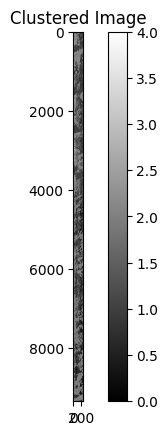

In [ ]:
plt.imshow(clustered_image, cmap='gray')
plt.title("Clustered Image")
plt.colorbar()
plt.show()

# Classification
* CNN

Splitting the data into traning and test sets.

In [ ]:
X = reduces_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1868000, 10)

* Defining the input shape of the data to the CNN Model.
* Then building the structure of the CNN model.

In [ ]:
X_train_cnn = X_train.reshape(-1, 10, 1, 1)
X_test_cnn = X_test.reshape(-1, 10, 1, 1)

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(10 ,1,1) ,  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu',  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 1, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 1, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 1, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 1, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 1, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 128)               0

Then compiling and fitting the model

In [ ]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
46700/46700 [==============================] - 346s 7ms/step - loss: 0.0457 - accuracy: 0.9807 - val_loss: 0.0573 - val_accuracy: 0.9761
Epoch 2/10
46700/46700 [==============================] - 354s 8ms/step - loss: 0.0395 - accuracy: 0.9832 - val_loss: 0.0294 - val_accuracy: 0.9877
Epoch 3/10
46700/46700 [==============================] - 363s 8ms/step - loss: 0.0359 - accuracy: 0.9847 - val_loss: 0.0529 - val_accuracy: 0.9783
Epoch 4/10
46700/46700 [==============================] - 356s 8ms/step - loss: 0.0332 - accuracy: 0.9859 - val_loss: 0.0523 - val_accuracy: 0.9789
Epoch 5/10
46700/46700 [==============================] - 341s 7ms/step - loss: 0.0312 - accuracy: 0.9867 - val_loss: 0.0380 - val_accuracy: 0.9830
Epoch 6/10
46700/46700 [==============================] - 350s 7ms/step - loss: 0.0297 - accuracy: 0.9874 - val_loss: 0.0236 - val_accuracy: 0.9897
Epoch 7/10
46700/46700 [==============================] - 372s 8ms/step - loss: 0.0286 - accuracy: 0.9877 - val_

In [58]:
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Accuracy: {cnn_eval[1]}')

14594/14594 [==============================] - 79s 5ms/step - loss: 0.0264 - accuracy: 0.9883
CNN Accuracy: 0.9883254766464233


ON TEST SET OUR MODEL IS GIVING ACCURACY OF MORE THAN 98%